# Sunshine Duration Forecasting using State-of-the-Art Deep Learning Models and ML Tools

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os

# change current working directory
os.chdir('/content/gdrive/My Drive/MRP/')

Mounted at /content/gdrive


In [ ]:
# Create Directories
DIR_DATA = 'data/'
DIR_RAW = f'{DIR_DATA}raw_data/'
DIR_PROCESSED = f'{DIR_DATA}processed_data/'
DIR_FIGURES_EDA = 'eda_figures/'
DIR_RESULTS = 'results/'

for path in [DIR_RAW, DIR_PROCESSED, DIR_FIGURES_EDA, DIR_RESULTS]:

    if not os.path.exists(path):
            os.makedirs(path)

    if path == DIR_RESULTS:

        p_clean_experiments = f'{path}clean_experiments/'
        p_outlier_experiments = f'{path}outlier_experiments/'

        DIR_RESULTS_FIGURES_CLEAN = f'{p_clean_experiments}figures/'
        DIR_RESULTS_FIGURES_OUTLIERS = f'{p_outlier_experiments}figures/'
        DIR_HYPERPARAMS_CLEAN = f'{p_clean_experiments}hyperparam_tuning/'
        DIR_HYPERPARAMS_OUTLIERS= f'{p_outlier_experiments}hyperparam_tuning/'
        DIR_TRIALS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}trials/'
        DIR_TRIALS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}trials/'
        DIR_TRIALS_FIGS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}figures/'
        DIR_TRIALS_FIGS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}figures/'
        DIR_MODEL_RESULTS_CLEAN = f'{p_clean_experiments}model_results/'
        DIR_MODEL_RESULTS_OUTLIERS = f'{p_outlier_experiments}model_results/'
        DIR_MODELS_CLEAN = f'{p_clean_experiments}models/'
        DIR_MODELS_OUTLIERS = f'{p_outlier_experiments}models/'

        directories = [DIR_RESULTS_FIGURES_CLEAN, DIR_RESULTS_FIGURES_OUTLIERS,
                       DIR_HYPERPARAMS_CLEAN, DIR_HYPERPARAMS_OUTLIERS,
                       DIR_TRIALS_CLEAN, DIR_TRIALS_OUTLIERS,
                       DIR_TRIALS_FIGS_CLEAN, DIR_TRIALS_FIGS_OUTLIERS,
                       DIR_MODEL_RESULTS_CLEAN, DIR_MODEL_RESULTS_OUTLIERS,
                       DIR_MODELS_CLEAN, DIR_MODELS_OUTLIERS]

        for p in directories:
            if not os.path.exists(p):
                os.makedirs(p)

In [ ]:
!pip install -U optuna
!pip install optuna-integration
!pip install 'u8darts[all]'
!pip install kaleido==0.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import copy
import datetime
import importlib
import logging
logging.disable(logging.CRITICAL)
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objs as go
import random
import requests
import seaborn as sns
import sys
import time
import torch

from darts import concatenate
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import RandomForest # for preliminary experiment; all other model calls are handled in the processing_functions.py module
from darts.models.forecasting.baselines import NaiveDrift, NaiveSeasonal, NaiveMean, NaiveMovingAverage
from darts.utils.callbacks import TFMProgressBar
from darts.utils.utils import SeasonalityMode
from datetime import datetime as dt
from project_code import processing_functions as pf, visualization_functions as vf, hyperparam_search as hp
from sklearn.preprocessing import MinMaxScaler


## Data Acquisition

The data for this project is sourced through Open-Meteo's free Historical Weather API, which does not require a developer key for access. It is collected for a geolocation that corresponds to Bordj Badji Mokhtar in Algeria.

### Selections for Data Download

**General Details:**

- Data Source: https://open-meteo.com/en/docs/historical-weather-api

**Bordj Badji Mokhtar (BBM) Details:**

- **Latitude:** 21.3292
- **Longitude:** 0.94791
- **Timezone:** Virtual Private Network (VPN) settings were set to 'DZ' (Algeria) and Timezone to 'Automatically detect time zone' because Central European Standard Time (GMT +1) or equivalent is not readily available as an option
- **Start Date:** 1994-01-01
- **End Date:** 2023-12-31

**Hourly Weather Variables:**
- **Temperature (2 m)**
- **Relative Humidity (2 m)**

**Additional Variables:**
- **Sunshine Duration**

Although Daily Weather Variables are directly available, Relative Humidity information is only available under Hourly Variables, so the data is procured at that level of granularity. Additionally, information is collected from 1995 onwards so that there is a large enough dataset for deep learning purposes, but only 2002 to 2006 will be used for the El-kenawy et al. comparison analysis.

**Settings:**

- **Temperature Unit:** Celsius  
- **Wind Speed Unit:** Km/h  
- **Precipitation Unit:** Millimeter  
- **Timeformat:** ISO 8601 (e.g. 2022-12-31)


**API Call:**

- https://archive-api.open-meteo.com/v1/era5?latitude=21.3292&longitude=0.94791&start_date=1994-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,sunshine_duration&timezone=auto

Per the documentation, we specify 'era5' in the API call in order to get data from the ERA5 reanalysis model, thereby ensuring data consistency, and preventing the capture of unintentional alterations that may have arisen from the adoption of different weather model upgrades.



In [ ]:
# Download data from Open Meteo
file_name = 'era5_data_BordjBadjiMokhtar.json'
api_call = 'https://archive-api.open-meteo.com/v1/era5?latitude=21.3292&longitude=0.94791&start_date=1994-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,sunshine_duration&timezone=auto'
pf.download_data(api_call, DIR_RAW, file_name)

Data successfully downloaded to data/raw_data/era5_data_BordjBadjiMokhtar.json.


In [ ]:
# read in data
file = f'{DIR_RAW}{file_name}'
data_bbm = pf.df_from_json(file)
data_bbm.name = 'Bordj Badji Mokhtar Open Meteo Data - Hourly'
pf.generate_df_summary(data_bbm, name=True)

Dataframe: Bordj Badji Mokhtar Open Meteo Data - Hourly

------ Head: ------


,time,temperature_2m,relative_humidity_2m,sunshine_duration
0,1994-01-01T00:00,12.4,34,0.0
1,1994-01-01T01:00,11.4,36,0.0
2,1994-01-01T02:00,10.5,37,0.0
3,1994-01-01T03:00,9.7,37,0.0
4,1994-01-01T04:00,8.9,37,0.0




------ Tail: ------


,time,temperature_2m,relative_humidity_2m,sunshine_duration
262963,2023-12-31T19:00,24.4,11,0.0
262964,2023-12-31T20:00,21.5,13,0.0
262965,2023-12-31T21:00,20.4,13,0.0
262966,2023-12-31T22:00,19.3,13,0.0
262967,2023-12-31T23:00,18.0,14,0.0




------ Column Summaries: ------


,count,unique,top,freq
time,262968,262968,1994-01-01T00:00,1


,count,mean,std,min,25%,50%,75%,max
temperature_2m,262968.0,28.040200,9.081526,1.4,21.3,28.8,35.2,46.9
relative_humidity_2m,262968.0,18.812570,11.562204,2.0,11.0,16.0,24.0,99.0
sunshine_duration,262968.0,1623.146004,1761.774532,0.0,0.0,0.0,3600.0,3600.0




------ Counts: ------

Rows: 262,968
Columns: 4
Duplicate Rows = 0 | % of Total Rows = 0.0%


------ Info: ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262968 entries, 0 to 262967
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  262968 non-null  object 
 1   temperature_2m        262968 non-null  float64
 2   relative_humidity_2m  262968 non-null  int64  
 3   sunshine_duration     262968 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 8.0+ MB


None



------ Missing Data Percentage: ------


,0
time,0.0
temperature_2m,0.0
relative_humidity_2m,0.0
sunshine_duration,0.0


Based on a preliminary assessment, there is no duplicate or missing data present.



## Exploratory Daata Analysis

In [ ]:
df_daily = pf.daily_aggregations(data_bbm)
df_daily.name = 'Bordj Badji Mokhtar - Daily Aggregations'
df_daily.head(3)

,sunshine_hr,humidity_mean,temp_min,temp_mean,temp_max,temp_range
date,,,,,,
1994-01-01,10.0,29.833333,5.9,13.366667,20.8,14.9
1994-01-02,10.0,31.666667,3.2,12.654167,21.1,17.9
1994-01-03,10.0,23.958333,5.7,15.166667,24.3,18.6


In [ ]:
pf.generate_df_summary(df_daily, describe_only=True, name=True)

Dataframe: Bordj Badji Mokhtar - Daily Aggregations

------ Column Summaries: ------


,count,mean,std,min,25%,50%,75%,max
sunshine_hr,10957.0,10.820973,1.250392,0.000000,10.110119,10.817328,11.918311,12.084744
humidity_mean,10957.0,18.812570,8.893567,3.291667,12.541667,17.083333,23.083333,85.708333
temp_min,10957.0,20.045587,7.583512,1.400000,13.400000,21.100000,26.900000,34.800000
temp_mean,10957.0,28.040200,7.480956,7.554167,21.275000,29.658333,35.033333,41.045833
temp_max,10957.0,34.975997,7.170943,13.100000,28.800000,36.700000,41.400000,46.900000
temp_range,10957.0,14.930410,2.650838,3.500000,13.200000,15.000000,16.800000,24.300000


Sunshine duration (SD) ranges from 0h to 12h, while the temperature ranges from 1.4C to 46.9C; the latter range is derived from the minimum value of the temp_min column and the maximum value of the max_temp column. The widest temperature range on any given day is 24.3C.

Correlations



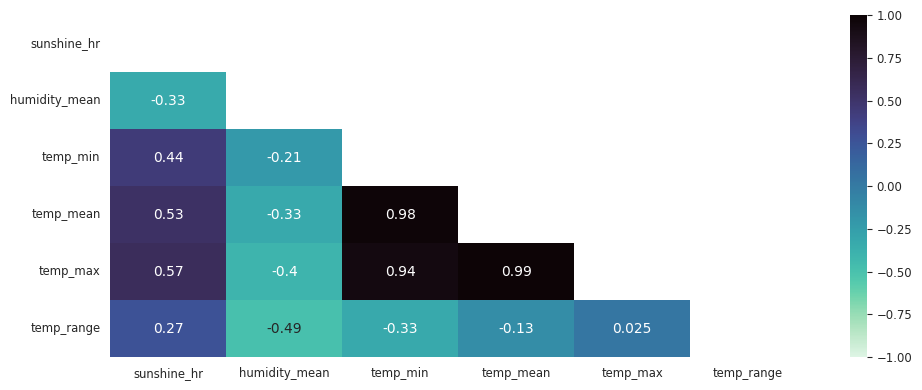

In [ ]:
sns.set_style("white")
print('Correlations\n')
vf.correlation_matrix(df_daily, figsize=(10,4), cmap='mako_r', name='correlations')

Maximum (0.57) and mean (0.53) temperature values are most strongly correlated with SD. However, these values indicate a generally moderate relationship. Mean humidity has a weak negative correlation with SD, at -0.33.

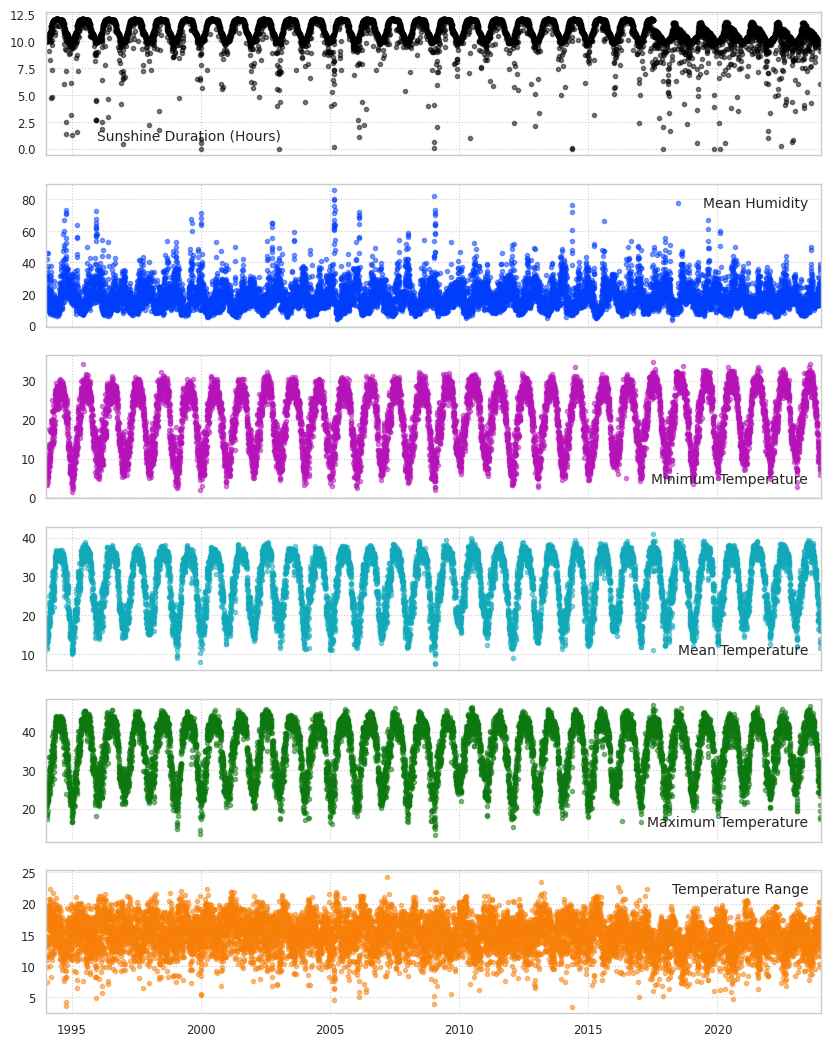

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})

# cols = ['sunshine_hr', 'temp_max', 'temp_range', 'humidity_mean']
df_daily.rename(columns={'sunshine_hr': 'Sunshine Duration (Hours)',
                        'temp_max': 'Maximum Temperature',
                        'temp_mean': 'Mean Temperature',
                        'temp_min': 'Minimum Temperature',
                        'temp_range': 'Temperature Range',
                        'humidity_mean': 'Mean Humidity'})\
                        .plot(marker='.',
                            alpha=0.5,
                            linestyle='None',
                            figsize=(10, 13),
                            subplots=True)
plt.xlabel('')
plt.show()

Sunshine Duration and Temperature exhibit a very clear annual seasonal pattern. There appears to have been a change in the shape of SD's pattern since ~2017, particularly with regards to its peak.


**Zeroing in on Sunshine Duration via decomposition:**

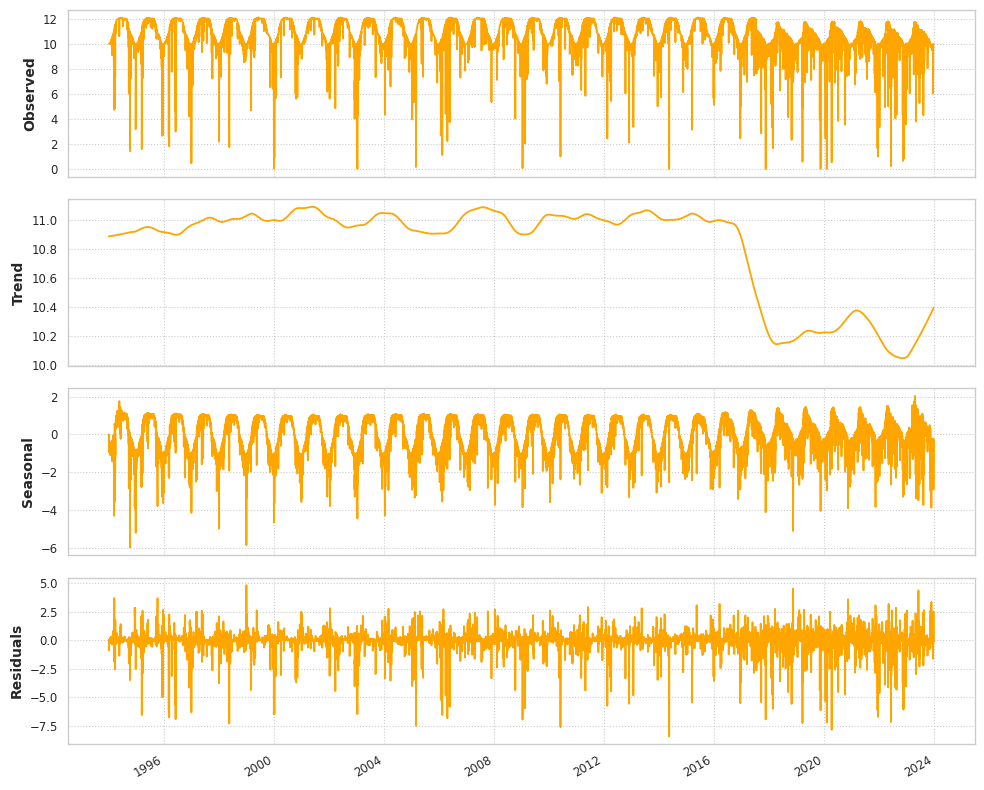

In [ ]:
vf.plot_seasonal_decomposition(df_daily, column='sunshine_hr', period=365, color='orange',
                               name='seasonal_decomposition')

Looking at the Trend chart, there is a sharp dip circa 2017 that had yet to have fully rebounded by the end of 2023; this has had a visible impact on the Residuals.

Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)



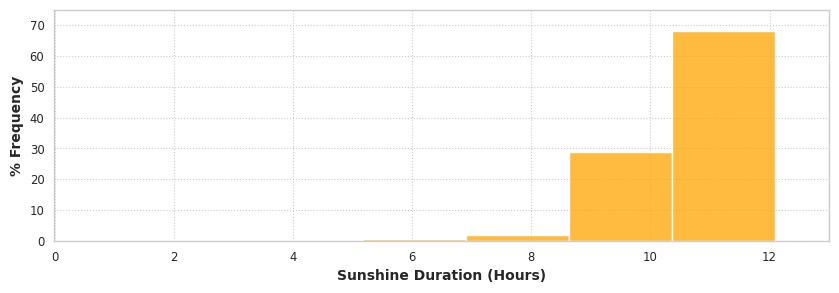

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.figure(figsize=(10,3))
sns.histplot(df_daily, x='sunshine_hr', bins=7, color='orange',
            stat='percent')
# plt.title('Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)')
print('Bordj Badji Mokhtar Hourly Sunshine Duration (1995-2023)\n')
plt.xlabel('Sunshine Duration (Hours)')
plt.ylabel('% Frequency')
plt.xlim(-0.01, 13)
plt.ylim(0,75)
plt.grid(True)
plt.savefig(f'{DIR_FIGURES_EDA}hourly_sd_frequency.png')
plt.show()

In [ ]:
data_len = len(df_daily)
prop_bw_102_12 = len(df_daily[(df_daily['sunshine_hr'] >= 10.2) & (df_daily['sunshine_hr'] <=12.08)]) / data_len
prop_less_than_3 = len(df_daily[df_daily['sunshine_hr'] <= 8.5]) / data_len

print(f'{prop_bw_102_12:.1%} of the observed sunshine duration is between 10.2h\
 and 12h, and {prop_less_than_3:.1%} is below 8.5h')

72.2% of the observed sunshine duration is between 10.2h and 12h, and 2.9% is below 8.5h


In [ ]:
# Time-based variables for monthly and annual stats
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['day_of_year'] = df_daily.index.day_of_year


month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
               'September', 'October', 'November', 'December']

month_label_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
               'Sep', 'Oct', 'Nov', 'Dec']

annual_monthly_means = df_daily.loc[:, ['sunshine_hr','year', 'month']].groupby(['year','month']).mean().reset_index()
daily_means = df_daily.loc[:, ['sunshine_hr','day_of_year']].groupby('day_of_year').mean().reset_index()

monthly_subset_means = {}

num_yrs_rolling_avg = 7

for idx, month in enumerate(month_labels):
    monthly_data = annual_monthly_means[annual_monthly_means['month'] == idx+1]
    monthly_data[f'{num_yrs_rolling_avg}yr_rolling_avg'] = monthly_data.sunshine_hr.rolling(num_yrs_rolling_avg).mean()
    monthly_subset_means[month] = monthly_data

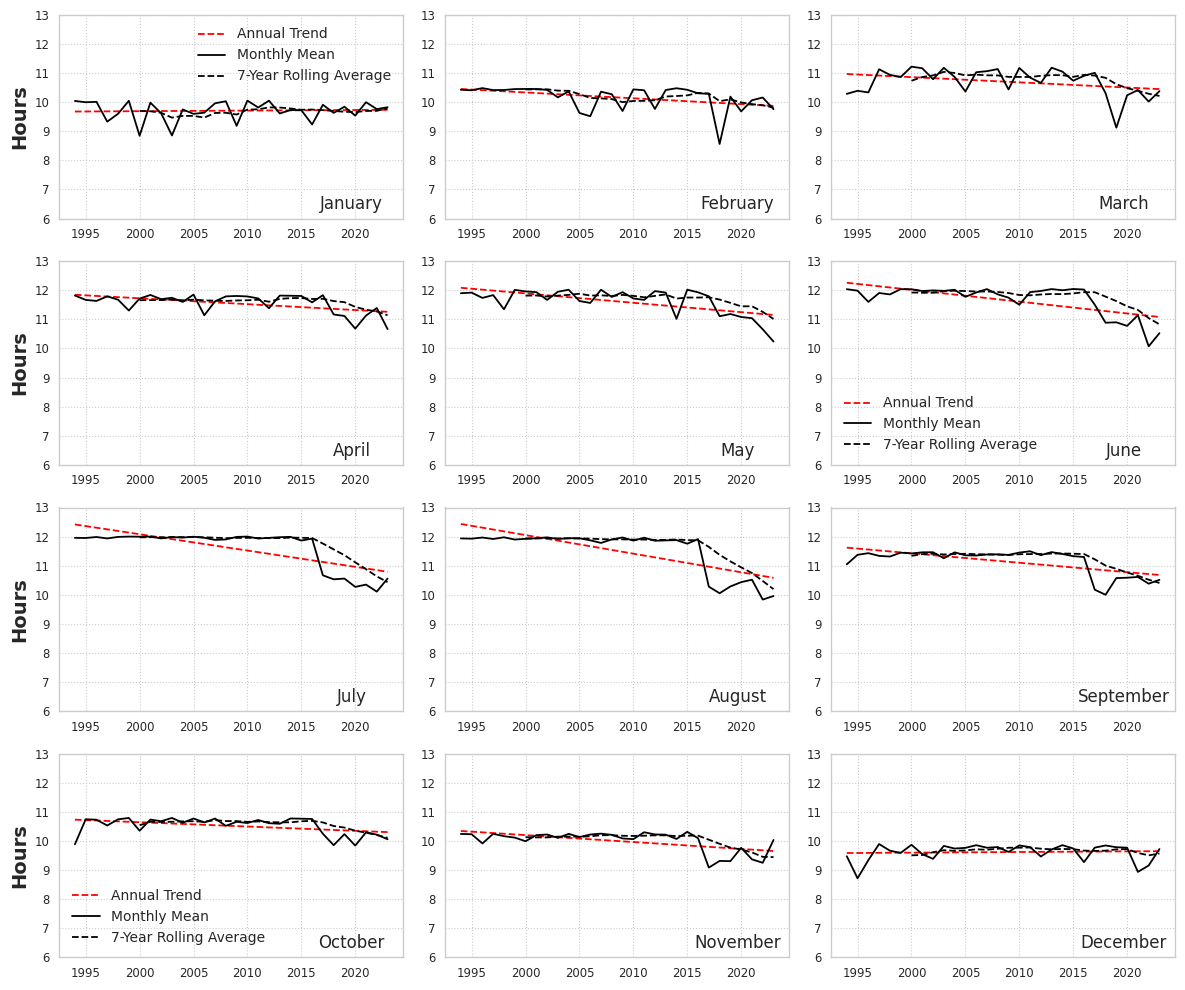

In [ ]:
sns.set_style("whitegrid", {'grid.linestyle': ':'})
vf.plot_monthly_charts(monthly_data=monthly_subset_means, num_yrs_rolling_avg=num_yrs_rolling_avg,
                        column='sunshine_hr', figsize=(12, 10),
                        x_label='', x_font_size=12,
                        y_label='Hours',  y_font_size=14,
                        ylim_start=6, name='monthly_sunshine_trends')


There has been a downward annual trend for most of the months, and the steepest ones can be seen in June through August, with the accompanying sharp downward slope for the 7-year rolling average. The now-familiar ~2017 dip can be observed across numerous months. There have been year-over-year fluctuations in December and January, but the annual trend for these months is relatively flat.

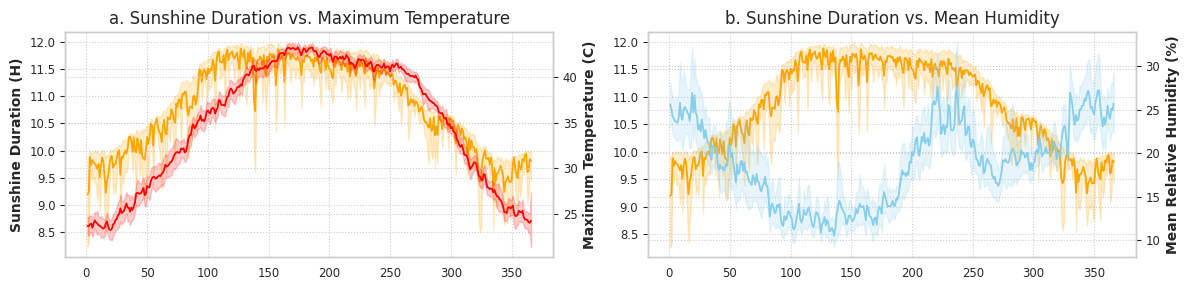

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
# fig.suptitle('Monthly Total Sunshine Duration', size=15)
sunshine_hr = 'sunshine_hr'
day_of_year = 'day_of_year'

# Plot Daily Sunshine Duration vs. Max Temperature and Relative Humidity
sns.lineplot(ax=axes[0], data=df_daily, x=day_of_year, y=sunshine_hr, color='orange')
axes[0].set_ylabel('Sunshine Duration (H)')
axes[0].set_xlabel('')
axes[0].set_title('a. Sunshine Duration vs. Maximum Temperature')
ax2 = axes[0].twinx()
sns.lineplot(ax=ax2, data=df_daily, x=day_of_year, y='temp_max', color='r')
ax2.set_ylabel('Maximum Temperature (C)')

sns.lineplot(ax=axes[1], data=df_daily, x=day_of_year, y=sunshine_hr, color='orange')
axes[1].set_title('b. Sunshine Duration vs. Mean Humidity')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
ax4 = axes[1].twinx()
sns.lineplot(ax=ax4, data=df_daily, x=day_of_year, y='humidity_mean', color='skyblue')
ax4.set_ylabel('Mean Relative Humidity (%)')

fig.tight_layout()
plt.savefig(f'{DIR_FIGURES_EDA}daily_trends.png')

Maximum Temperature and Sunshine Duration generally follow the same trend and maintain their relationship throughout most of the year. Relative Mean Humidity, on the other hand, displays a pronounced inverse relationship with SD during various parts of the year.

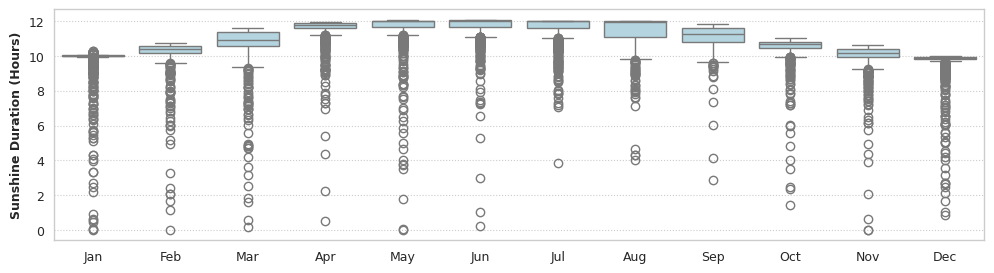

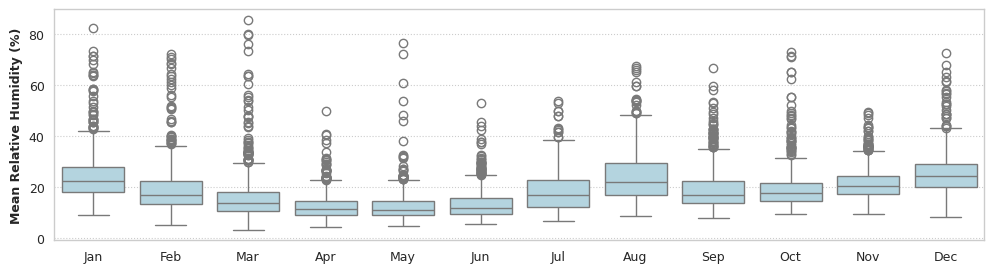

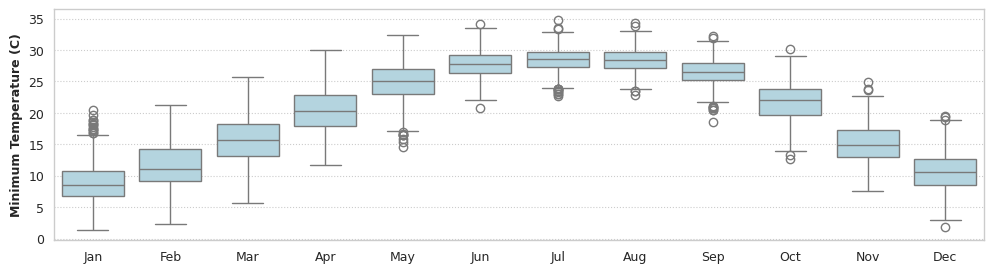

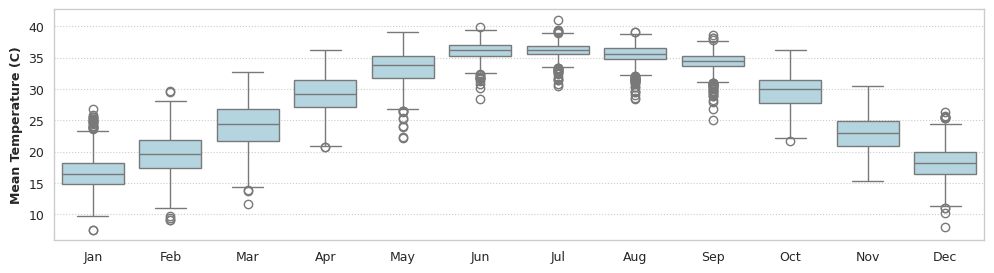

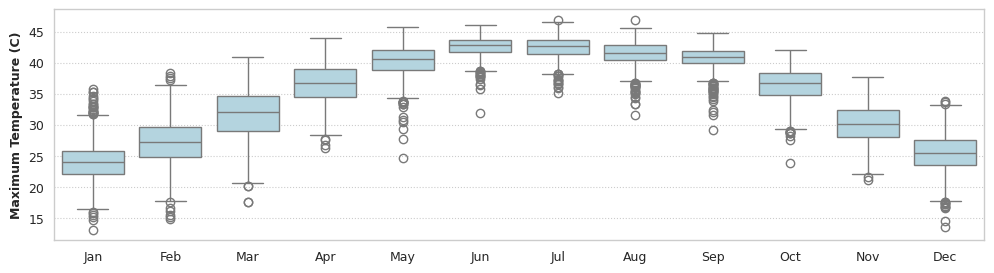

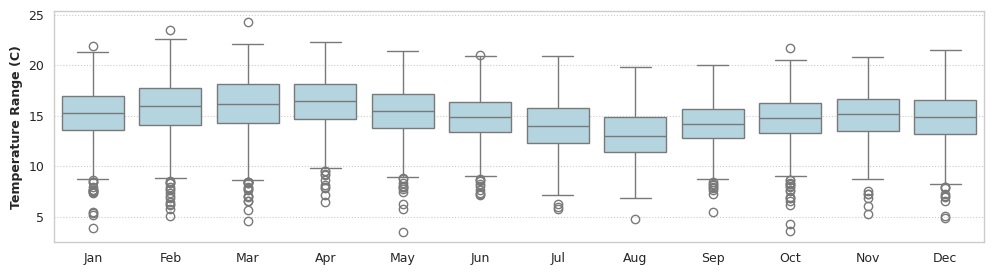

In [ ]:
# Outlier Assessment

y_labels = {
    'sunshine_hr': 'Sunshine Duration (Hours)',
    'temp_min': 'Minimum Temperature (C)',
    'temp_mean': 'Mean Temperature (C)',
    'temp_max': 'Maximum Temperature (C)',
    'temp_range': 'Temperature Range (C)',
    'humidity_mean': 'Mean Relative Humidity (%)',
}

cols_to_plot = df_daily.columns[:-3]

vf.generate_boxplots(data=df_daily, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(12,3), label_font_size=9, tick_font_size=9)



  
The outliers are assessed using a monthly lens. Quite a number of them can be observed in the sunshine duration and relative mean humidity fields. For the purposes of the upcoming experiments, model performance will be tested on two versions of the data: one with, and one without outliers. The former is in keeping with El-kenawy et al's process, particularly as the current study will seek to replicate a portion of their findings. It is also done because there are no solid indicators that the outliers are the result of bad data, so they will be treated as legitimate. The "clean" dataset will be created by selecting the outlier values in each column and clipping them at +/- 1.5 * IQR (i.e. the limits beyond which a data point is generally considered to be an outlier).

In [ ]:
df_clean = pf.adjust_outliers(df_daily, columns=cols_to_plot, granularity='month')

Total outliers adjusted in the sunshine_hr column: 1,299
Percent of total rows: 11.86%


Total outliers adjusted in the humidity_mean column: 419
Percent of total rows: 3.82%


Total outliers adjusted in the temp_min column: 63
Percent of total rows: 0.57%


Total outliers adjusted in the temp_mean column: 158
Percent of total rows: 1.44%


Total outliers adjusted in the temp_max column: 171
Percent of total rows: 1.56%


Total outliers adjusted in the temp_range column: 125
Percent of total rows: 1.14%




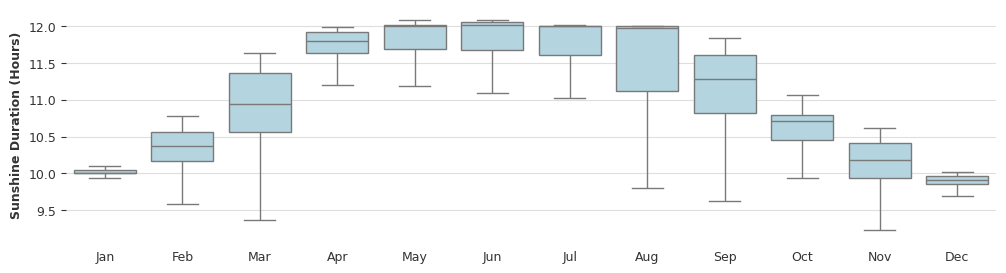

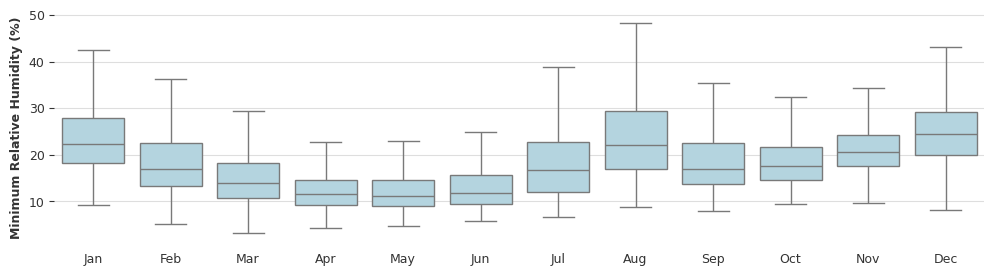

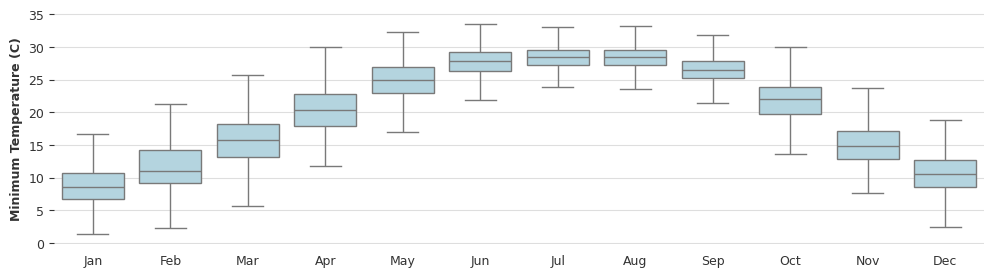

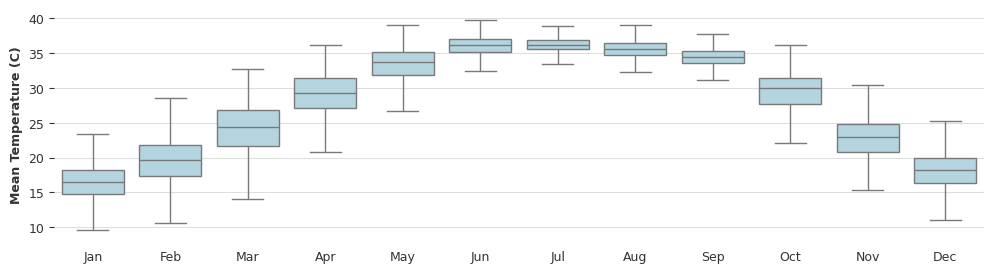

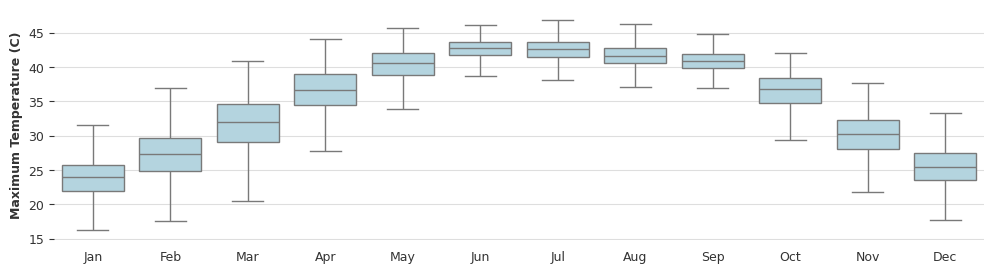

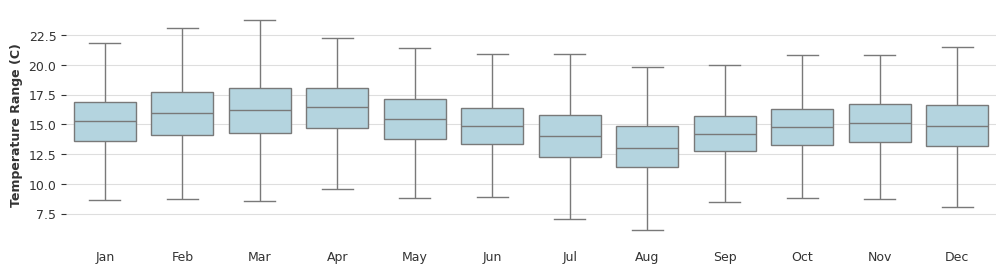

In [ ]:
# Clean data boxplots
vf.generate_boxplots(data=df_clean, columns=cols_to_plot, granularity='month',
                     alternate_x_labels=month_label_abbr, y_labels=y_labels,
                    figsize=(12,3), label_font_size=9, tick_font_size=9)

Clearing the outliers has shrunk the SD range from 12 hours to less than 3 hours (~9.2h to 12h), which may have some implication for the experiment results. This smaller range could potentially leave room for the overestimation of model performance.

In [ ]:
df_daily.drop(['year', 'month', 'day_of_year'], axis=1, inplace=True)
df_daily.to_csv(f'{DIR_PROCESSED}data_bbm_outliers.csv')
df_clean.drop(['year', 'month', 'day_of_year'], axis=1, inplace=True)
df_clean.to_csv(f'{DIR_PROCESSED}data_bbm_clean.csv')

data_bbm_outliers = df_daily.copy()
data_bbm_clean = df_clean.copy()

## Preliminary Experiment: Selecting a Naive Baseline Model

In order to ensure proper performance contextualization for both the novel and traditional ML models, a preliminary experiment is conducted to select a baseline comparator model. The performance of the baseline models provided by Darts is tested, and a final selection is made based on rmse and mae scores. A date other than the one generated for the main experiments is used, to avoid biasing the results. The same date will be used in the hyperparameter selection section.


In [ ]:
seed = 34
FORECAST_HORIZONS = (1, 3, 7, 14, 28)

naive_models = ['naive_drift', 'naive_seasonal', 'naive_mean', 'naive_moving_average']
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=seed, n=1)
print(f'\nSelected cutoff date: {cutoff_date}')

for version in ['outliers', 'clean']:
    print(f'\n---------- Dataset Type: {version} ----------\n')

    if version == 'outliers':
        target_train, target_test, _ = pf.train_test_split(cutoff_date, df_outliers=data_bbm_outliers,  has_outliers=True)
    else:
        target_train, target_test, _ = pf.train_test_split(cutoff_date, df_clean=data_bbm_clean,  has_outliers=False)

    avg_metrics, median_metrics = pf.get_naive_model_metrics(naive_models, FORECAST_HORIZONS,
                                                        train_data=target_train, test_data=target_test)
    print('\nAverage Error:', '\n')
    display(avg_metrics)
    print('\n')
    print('Median Error:', '\n')
    display(median_metrics)


Selected cutoff date: 2023-08-24

---------- Dataset Type: outliers ----------


Average Error: 



,model_name,rmse,mae
0,naive_drift,0.722636,0.458631
1,naive_mean,0.751342,0.466973
2,naive_moving_average,0.820939,0.783551
3,naive_seasonal,3.997902,3.302006




Median Error: 



,model_name,rmse,mae
0,naive_drift,0.774466,0.430788
2,naive_moving_average,0.819931,0.765991
1,naive_mean,0.845352,0.504116
3,naive_seasonal,3.613701,2.652277



---------- Dataset Type: clean ----------


Average Error: 



,model_name,rmse,mae
0,naive_drift,0.421124,0.307636
2,naive_moving_average,0.487098,0.449184
1,naive_mean,0.519673,0.393101
3,naive_seasonal,0.836710,0.768856




Median Error: 



,model_name,rmse,mae
0,naive_drift,0.445767,0.288900
2,naive_moving_average,0.502503,0.489075
1,naive_mean,0.637889,0.471184
3,naive_seasonal,0.796311,0.721739


Naive Drift displays the best performance in terms of both average and median error, so it is selected as the baseline comparator.


## Preliminary Experiment: Optuna vs. Grid Search

This experiment has two parts, with the first being the training of a random forest (RF) model on BBM data from 2002-2006, and comparing its performance to that obtained in El-kenawy et al. (2021)'s ensemble learning model experiment. The second part is assessing the respective performances of the Optuna hyperparameter optimization framework and Grid Search (GS) in arriving at optimal hyperparameters for the random forest model. The goal is to validate Optuna's ability to provide good results, as well as demonstrate its potential efficiency relative to GS.


In the referenced study:
- The dataset was "divided randomly into three subsets of training, validation, and testing (60, 20, and 20%, respectively)." However, given its time series nature, such a step carries the risk of data leakage because future data is dependent on past data, and information pertaining to the test set may inadvertently find its way into the training set. For the purposes of the current study, a cutoff date will be used instead.
- The parameters for the RF model were not disclosed.
- The fields used for SD prediction were: Relative Humidity (daily average relative humidity), Mean Air Temperature, Maximum Air Temperature, and Minimum Air Temperature.
- SD values were normalized using the min-max scaling method, and all the reported SD and associated RMSE and MSE values were dimensionless.

**Note:** the reported results for this part were from a locally run version of the experiment, as the Colab CPU instance took over twice as long to complete the GS search.

In [ ]:
subset = data_bbm_outliers.loc[(data_bbm_outliers.index.year >= 2002) & (data_bbm_outliers.index.year <= 2006)]
subset.drop('temp_range', axis=1, inplace=True)

# BBM RF results in El-kenawy et al study
comparison_rmse = 0.2164
comparison_mae = 0.1633

target = pf.create_timeseries(subset, 'sunshine_hr')
past_covariates = pf.get_covariate_ts(subset)

series_len = len(subset)
test_len = round(.2 * series_len)

# create training, testing, and validation datasets -> 60%-20%-20% split required
# '_main': for main test; '_sub': for validation process, pre-testing

target_train_main, target_test = target[:-test_len], target[-test_len:]
target_train_sub, target_val = target_train_main[:-test_len], target_train_main[-test_len:]

target_scaler1 = Scaler()
target_train_main_scaled = target_scaler1.fit_transform(target_train_main)
target_test_scaled = target_scaler1.transform(target_test)

target_scaler2 = Scaler()
target_train_sub_scaled = target_scaler2.fit_transform(target_train_sub)
target_val_scaled = target_scaler2.transform(target_val)

cov_train_main = past_covariates[:-test_len]
cov_train_sub = cov_train_main[:-test_len]

cov_scaler1 = Scaler()
cov_train_main_scaled = cov_scaler1.fit_transform(cov_train_main)
cov_scaler2 = Scaler()
cov_train_sub_scaled = cov_scaler2.fit_transform(cov_train_sub)


In [ ]:
print(f'2002-2006 data length: {series_len}\n')
print(f'Full Training Data: {len(target_train_main)/series_len:.1%} of total dataset')
print(f'Sub Training Data: {len(target_train_sub)/series_len:.1%} of total dataset')
print(f'Validation Data: {len(target_val)/series_len:.1%} of total dataset')
print(f'Test Data: {len(target_test)/series_len:.1%} of total dataset')


2002-2006 data length: 1826

Full Training Data: 80.0% of total dataset
Sub Training Data: 60.0% of total dataset
Validation Data: 20.0% of total dataset
Test Data: 20.0% of total dataset


In [ ]:
# hyperparameter search space
LAGS = [1, 3, 7, 14, 28, 60, 90, 120]
N_ESTIMATORS = [50, 100, 150, 200]
MAX_DEPTHS = [2, 3, 5, 8]

### Optuna

In [ ]:
all_results = {}
hyperparam_file_rf = f'{DIR_HYPERPARAMS_OUTLIERS}prelim_experiments_search_results_rf.json'
n_trials = 35

def objective_rf_prelim(trial):
    """Random Forest hyperparameter search objective"""

    # hyperparameter space
    rf_params = {
                    'lags': trial.suggest_categorical("lags", LAGS),
                    'lags_past_covariates': trial.suggest_categorical('lags_past_covariates', LAGS),
                    'n_estimators': trial.suggest_categorical('n_estimators', N_ESTIMATORS),
                    'max_depth': trial.suggest_categorical('max_depth',  MAX_DEPTHS),
                    'output_chunk_length': test_len
                    }

    model = RandomForest(**rf_params)

    model.fit(
                series=target_train_sub_scaled,
                past_covariates=cov_train_sub_scaled,
                )

    predictions_scaled = model.predict(
                                        n=test_len,
                                        series=target_train_sub_scaled,
                                        past_covariates=cov_train_sub_scaled,
                                        )

    rmse_result_scaled = rmse(predictions_scaled, target_val_scaled)

    return rmse_result_scaled

study = optuna.create_study(direction='minimize')
start_time = time.perf_counter()
study.optimize(objective_rf_prelim, n_trials)
end_time = time.perf_counter()
optuna_search_time = round((end_time - start_time)/60, 2)
print(f'Optuna Trials completed in {optuna_search_time} minutes')
print(f'Best RMSE (Scaled): {study.best_value:.4f}\nBest parameters: {study.best_trial.params}')

Optuna Trials completed in 13.63 minutes
Best RMSE (Scaled): 0.0841
Best parameters: {'lags': 28, 'lags_past_covariates': 120, 'n_estimators': 150, 'max_depth': 2}


In [ ]:
optuna_results = study.best_trial.params
optuna_results['search_time'] = optuna_search_time
optuna_results['rmse'] = study.best_value
all_results['optuna_results'] = optuna_results
pf.post_results(all_results, hyperparam_file_rf, 'w')


Successfully posted results to results/hyperparam_tuning/prelim_experiments_search_results_rf.json


### Grid Search

In [ ]:
parameters_rf = {
            'lags': LAGS,
            'lags_past_covariates': LAGS,
            'n_estimators': N_ESTIMATORS,
            'max_depth': MAX_DEPTHS,
            'output_chunk_length': [test_len]
        }

start_time = time.perf_counter()
grid_search_model, grid_search_results, rmse_grid_search = RandomForest.gridsearch(
                parameters=parameters_rf,
                series=target_train_sub_scaled,
                past_covariates=cov_train_sub_scaled,
                val_series=target_val_scaled,
                use_fitted_values=False,
                metric=rmse
            )
end_time = time.perf_counter()
gs_search_time = round((end_time - start_time)/60, 2)
print(f'Grid Search completed in {gs_search_time} minutes')
print(f'Best RMSE: {rmse_grid_search:.4f}\nBest parameters: {grid_search_results}')

Grid Search completed in 347.89 minutes
Best RMSE: 0.0831
Best parameters: {'lags': 3, 'lags_past_covariates': 14, 'n_estimators': 150, 'max_depth': 5, 'output_chunk_length': 365}


The grid search returns the following: 1) a tuple containing an *untrained* model_class instance created from the best-performing hyper-parameters; 2) a dictionary containing these best hyper-parameters; and 3)the metric score for the best hyper-parameters.

In [ ]:
grid_search_results['search_time'] = gs_search_time
grid_search_results['rmse'] = rmse_grid_search
all_results['grid_search_results'] = grid_search_results
pf.post_results(all_results, hyperparam_file_rf, 'w')

In [ ]:
print(f'Grid Search took {gs_search_time/optuna_search_time:.1f} times as long as Optuna to produce similar results ({optuna_search_time} minutes vs. {gs_search_time/60:.1f} hours).')

Grid Search took 25.5 times as long as Optuna to produce similar results (13.63 minutes vs. 5.8 hours).


### Tests

#### Optuna

In [ ]:
optuna_model = RandomForest(
                    lags=optuna_results['lags'],
                    lags_past_covariates=optuna_results['lags_past_covariates'],
                    n_estimators=optuna_results['n_estimators'],
                    max_depth=optuna_results['max_depth'],
                    output_chunk_length=test_len
                    )

optuna_model.fit(series=target_train_main_scaled,
                past_covariates=cov_train_main_scaled)

predictions = optuna_model.predict(
                                n=test_len,
                                series=target_train_main_scaled,
                                past_covariates=cov_train_main_scaled
                                )

rmse_score_o = rmse(predictions, target_test_scaled)
mae_score_o = mae(predictions, target_test_scaled)

print(f"RMSE score of {rmse_score_o:.4f} vs. El-kenawy et al.'s reported {comparison_rmse} RMSE.")
print(f"MAE score of {mae_score_o:.4f} vs. El-kenawy et al.'s reported {comparison_mae} MAE.")

RMSE score of 0.0962 vs. El-kenawy et al.'s reported 0.2164 RMSE.
MAE score of 0.0377 vs. El-kenawy et al.'s reported 0.1633 MAE.


#### Grid Search

In [ ]:
grid_search_model.fit(series=target_train_main_scaled,
                    past_covariates=cov_train_main_scaled)

predictions = grid_search_model.predict(
                                n=test_len,
                                series=target_train_main_scaled,
                                past_covariates=cov_train_main_scaled
                                )

rmse_score_g = rmse(predictions, target_test_scaled)
mae_score_g = mae(predictions, target_test_scaled)

print(f"RMSE score of {rmse_score_g:.4f} vs. El-kenawy et al.'s reported {comparison_rmse} RMSE.")
print(f"MAE score of {mae_score_g:.4f} vs. El-kenawy et al.'s reported {comparison_mae} MAE.")

RMSE score of 0.0970 vs. El-kenawy et al.'s reported 0.2164 RMSE.
MAE score of 0.0333 vs. El-kenawy et al.'s reported 0.1633 MAE.


In [ ]:
print(f"Optuna's RMSE and MAE scores are, respectively, {rmse_score_o - rmse_score_g:+.4f} and {mae_score_o - mae_score_g:+.4f} relative to GS's, \
and {(rmse_score_o - comparison_rmse)/comparison_rmse:+.1%} and {(mae_score_o - comparison_mae)/comparison_mae:+.1%} relative to El-kenawy et al's.\n")

print(f"GS's RMSE and MAE scores are, respectively, {(rmse_score_g - comparison_rmse)/comparison_rmse:+.1%} and {(mae_score_g - comparison_mae)/comparison_mae:+.1%} relative to El-kenawy et al's.\n")

Optuna's RMSE and MAE scores are, respectively, -0.0008 and +0.0044 relative to GS's, and -55.5% and -76.9% relative to El-kenawy et al's.

GS's RMSE and MAE scores are, respectively, -55.2% and -79.6% relative to El-kenawy et al's.



The tests once again confirm that Optuna and GS produce fairly similar results, with optimal hyperparameters that the former was able to determine in a fraction of the time taken by the latter. Furthermore, this study shows a ~55% improvement in RMSE and ~80% in MAE relative to the scores reported by El-kenawy et al.

## Hyperparameter Search for Main Experiment

### Set-up

In [ ]:
SEED = 25
BATCH_SIZES = [32, 64, 128, 256]
results_dict = {}

testing_cutoff_date = pd.Timestamp('2022-12-31') # save 2023 for main experiment testing
# cutoff/end date of Dec 3rd avoids errors, i.e. going beyond Dec 31 for Forecast Horizon=28
validation_cutoff_date = pd.Timestamp(pf.generate_cutoff_date(start_date='2022-01-01', end_date='2022-12-03', seed=SEED, n=1, replace=False))

target_train, _, cov_train = pf.train_test_split(cutoff_date=testing_cutoff_date, df_clean=data_bbm_clean, has_outliers=False) #NOTE: CHANGED TO CLEAN DATASET; removed df_outliers=data_bbm_outliers
target_train, target_val = target_train.split_after(validation_cutoff_date)
cov_train, _ = cov_train.split_after(validation_cutoff_date)

target_scaler = Scaler()
target_train_scaled = target_scaler.fit_transform(target_train)
cov_scaler = Scaler()
cov_train_scaled = cov_scaler.fit_transform(cov_train)

common_inputs = {
    'scaled_data': {
        'target_train': target_train_scaled,
        'cov_train': cov_train_scaled,
        'target_scaler': target_scaler,
        },
    'unscaled_data': {
        'target_train': target_train,
        'cov_train': cov_train,
    },
    'target_test': target_val,
    'batch_sizes': BATCH_SIZES,
    'seed': SEED
}


In [ ]:
print(f'Testing cut-off date: {testing_cutoff_date.strftime("%Y-%m-%d")}')
print(f'Validation cut-off date: {validation_cutoff_date.strftime("%Y-%m-%d")}\n')

print('Target Train Head: \n')
print(target_train.head(1), '\n')
print('\nTarget Train Tail: \n')
print(target_train.tail(1), '\n')

print('\nCov Train Head: \n')
print(cov_train.head(1), '\n')
print('\nCov Train Tail: \n')
print(cov_train.tail(1))

print('\nTarget Validation Head: \n')
print(target_val.head(1))


Testing cut-off date: 2022-12-31
Validation cut-off date: 2022-08-10

Target Train Head: 

<TimeSeries (DataArray) (date: 1, component: 1, sample: 1)> Size: 4B
array([[[10.]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 8B 1994-01-01
  * component  (component) object 8B 'sunshine_hr'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None 


Target Train Tail: 

<TimeSeries (DataArray) (date: 1, component: 1, sample: 1)> Size: 4B
array([[[9.799182]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 8B 2022-08-10
  * component  (component) object 8B 'sunshine_hr'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None 


Cov Train Head: 

<TimeSeries (DataArray) (date: 1, component: 5, sample: 1)> Size: 20B
array([[[29.833334],
        [ 5.9     ],
        [13.366667],
        [20.8     ],
        [14.9     ]]], dtype=float32)
Coordinates:
  * 

### Search

In [ ]:
#TO DO: TEST FOR PROPER FILE NAME CREATION
n_trials = 35

MODELS = ['lstm', 'gru', 'nbeats' 'nhits', 'rf', 'xgboost', 'lgbm'] # all models
# MODELS = ['lstm', 'gru', 'nbeats' 'nhits'] # DL models - for GPU purposes
# MODELS = ['rf', 'xgboost', 'lgbm'] # non-DL models - don't require GPU

for version in ['outlier', 'clean']:

    if version == 'outlier':
        directory = DIR_HYPERPARAMS_OUTLIERS
    else:
        directory = DIR_HYPERPARAMS_CLEAN

    for model_name in MODELS:
        hyperparam_file = f'{directory}optuna_results_{model_name}_{version}version.json'
        results_dict = {}

        for fh in FORECAST_HORIZONS:

            if model_name in ['lstm', 'gru']:
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version=model_name, error_metric='rmse', seed=SEED, results_directory=directory)
            elif model_name == 'nbeats':
                n_trials = 20
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version='generic', error_metric='rmse', seed=SEED, results_directory=directory)
            else:
                if model_name == 'nhits':
                    n_trials = 20
                hp.hyperparameter_search(fh, model_name, common_inputs, n_trials, results_dict,
                            hyperparam_file, version=None, error_metric='rmse', seed=SEED, results_directory=directory)


## Main Experiments

Note: Image Titles are ommitted for the purposes of inclusion in the major research paper, where figure names will be used instead.

In [ ]:
# importlib.reload(pf)
SEED = 50
MODEL_NAMES = {
    'naive_drift': 'Naive Drift',
    'ets': 'Exponential Smoothing',
    'rf': 'Random Forest',
    'xgboost': 'XGBoost',
    'lgbm': 'LightGBM',
    'lstm': 'LSTM',
    'gru': 'GRU',
    'nbeats': 'N-BEATS',
    'nhits': 'N-HiTS'
}

# # compile hyperparameter search results
hyperparams_file = f'{DIR_HYPERPARAMS}optuna_results.json' #TODO: Update to account for separate conditions
hyperparams = {}

for name in MODEL_NAMES.keys():
    if name in ['naive_drift', 'ets']:
        continue
    try:
        hyperprms = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results_{name}.json')
        hyperparams.update(hyperprms)
    except:
        continue

# pf.post_results(hyperparams, hyperparams_file, mode='w')

# reformat the hyperparameter dictionary
hyparams_reformatted = pf.get_reformatted_hyperparams(hyperparams, forecast_horizons=FORECAST_HORIZONS)

# generate cut-off date for the experiments (i.e. the next 1-28 days after the cutoff will become test data)
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=SEED, n=1)
cutoff_date2 = pf.generate_cutoff_date(start_date='2023-08-01', end_date='2023-08-31', seed=SEED, n=1)
print(f'\nThe randomly selected cutoff_date for the main experiments is: {cutoff_date}')
print(f'\nThe randomly selected cutoff_date for the main experiments w/ same month as validation is: {cutoff_date2}')



The randomly selected cutoff_date for the main experiments is: 2023-04-09

The randomly selected cutoff_date for the main experiments w/ same month as validation is: 2023-08-19


In [ ]:

for model_name in ['naive_drift', 'ets', 'rf', 'xgboost', 'lgbm', 'lstm', 'gru', 'nbeats' 'nhits']:

    april = cutoff_date
    august = cutoff_date2

    for cutoff_date in [april, august]:

        for model_name in ['naive_drift', 'ets', 'rf', 'xgboost', 'lgbm', 'lstm', 'gru', 'nbeats', 'nhits']:

            results = {
                        'model_name_proper': [],
                        'model_name_fh': [],
                        'model_type': [],
                        'has_outliers': [],
                        'forecast_horizon': [],
                        'rmse': [],
                        'mae': [],
                        'n_epochs': [],
                        'has_n_epochs_override': [],
                        'training_time': [],
                        'hyp_search_time': [],
                        'best_val_rmse': [],
                        'total_time': []
                    }

            for model_type in ['default', 'tuned']:

                if model_name == 'nbeats':

                    for version in ['generic', 'interpretable']:

                        if version == 'interpretable' and model_type == 'tuned':
                            continue

                        for has_outliers in [True, False]:

                            for fh in FORECAST_HORIZONS:

                                if model_type == 'default':

                                    n_epochs_override = None

                                    model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                version=version, model_type=model_type, n_epochs_override=n_epochs_override)

                                    model_name_proper = MODEL_NAMES[model_name]
                                    model_names = [model_name, model_name_proper, model_name_fh]

                                    pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                            df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                            models_directory=DIR_MODELS, results_directory=DIR_MODEL_RESULTS)
                                else:

                                    for n_epochs_override in [None, 100]:

                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                    version=version, model_type=model_type, n_epochs_override=n_epochs_override)

                                        model_name_proper = MODEL_NAMES[model_name]
                                        model_names = [model_name, model_name_proper, model_name_fh]

                                        pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                                df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                                models_directory=DIR_MODELS, results_directory=DIR_MODEL_RESULTS)

                else:

                    for has_outliers in [True, False]:

                            for fh in FORECAST_HORIZONS:

                                if model_type == 'default':

                                    n_epochs_override = None

                                    if model_name in ['lstm', 'gru']:
                                        version = model_name.upper()
                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                version=version, model_type=model_type, n_epochs_override=n_epochs_override)
                                    else:
                                        model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                            model_type=model_type, n_epochs_override=n_epochs_override)

                                    model_name_proper = MODEL_NAMES[model_name]
                                    model_names = [model_name, model_name_proper, model_name_fh]

                                    pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                            df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                            models_directory=DIR_MODELS, results_directory=DIR_MODEL_RESULTS)

                                else:

                                    if model_name in ['naive_drift', 'ets']:
                                        continue

                                    for n_epochs_override in [None, 100]:

                                        if n_epochs_override is not None and model_name in ['rf', 'xgboost', 'lgbm']:
                                            continue

                                        if model_name in ['lstm', 'gru']:
                                            version = model_name.upper()
                                            model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                    version=version, model_type=model_type, n_epochs_override=n_epochs_override)
                                        else:
                                            model, model_name_fh,  n_epochs_override = pf.get_model(model_name=model_name, fh=fh, hyperparams=hyparams_reformatted, seed=SEED,
                                                                                model_type=model_type, n_epochs_override=n_epochs_override)

                                        model_name_proper = MODEL_NAMES[model_name]
                                        model_names = [model_name, model_name_proper, model_name_fh]

                                        pf.run_experiment(model, model_names, n_epochs_override, hyperparameters=hyperparams, cutoff_date=cutoff_date, fh=fh,
                                                df_outliers=data_bbm_outliers, df_clean=data_bbm_clean, has_outliers=has_outliers, results=results,
                                                models_directory=DIR_MODELS, results_directory=DIR_MODEL_RESULTS)




In [ ]:
# Compile results
april = cutoff_date
august = cutoff_date2
outlier_condition = 'Hyperparam-Outlier'
clean_condition = 'Hyperparam-Clean'

DIR_APRIL_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={april}/'
DIR_APRIL_CL = f'{DIR_MODEL_RESULTS_CLEAN}cutoff_date={april}/'
DIR_AUGUST_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={august}/'

res_nd_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}naive_drift_cutoffdate={april}_results.csv')
res_ets_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}ets_cutoffdate={april}_results.csv')
res_rf_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}rf_cutoffdate={april}_results.csv')
res_xgb_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}xgboost_cutoffdate={april}_results.csv')
res_lgbm_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}lgbm_cutoffdate={april}_results.csv')
res_lstm_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}lstm_cutoffdate={april}_results.csv')
res_gru_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}gru_cutoffdate={april}_results.csv')
res_nbeats_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}nbeats_cutoffdate={april}_results.csv')
res_nhits_april_outl = pd.read_csv(f'{DIR_APRIL_OUTL}nhits_cutoffdate={april}_results.csv')

res_april_outl = pd.concat([res_nd_april_outl, res_ets_april_outl, res_rf_april_outl, res_xgb_april_outl, res_lgbm_april_outl,
                            res_lstm_april_outl, res_gru_april_outl, res_nbeats_april_outl, res_nhits_april_outl],
                            axis=0).reset_index(drop=True)

res_april_outl['experiment_condition'] = outlier_condition

res_nd_april_cl = pd.read_csv(f'{DIR_APRIL_CL}naive_drift_cutoffdate={april}_results.csv')
res_ets_april_cl = pd.read_csv(f'{DIR_APRIL_CL}ets_cutoffdate={april}_results.csv')
res_rf_april_cl = pd.read_csv(f'{DIR_APRIL_CL}rf_cutoffdate={april}_results.csv')
res_xgb_april_cl = pd.read_csv(f'{DIR_APRIL_CL}xgboost_cutoffdate={april}_results.csv')
res_lgbm_april_cl = pd.read_csv(f'{DIR_APRIL_CL}lgbm_cutoffdate={april}_results.csv')
res_lstm_april_cl = pd.read_csv(f'{DIR_APRIL_CL}lstm_cutoffdate={april}_results.csv')
res_gru_april_cl = pd.read_csv(f'{DIR_APRIL_CL}gru_cutoffdate={april}_results.csv')
res_nbeats_april_cl = pd.read_csv(f'{DIR_APRIL_CL}nbeats_cutoffdate={april}_results.csv')
res_nhits_april_cl = pd.read_csv(f'{DIR_APRIL_CL}nhits_cutoffdate={april}_results.csv')

res_april_cl = pd.concat([res_nd_april_cl, res_ets_april_cl, res_rf_april_cl, res_xgb_april_cl, res_lgbm_april_cl,
                            res_lstm_april_cl, res_gru_april_cl, res_nbeats_april_cl, res_nhits_april_cl],
                            axis=0).reset_index(drop=True)

res_april_cl['experiment_condition'] = clean_condition

res_nd_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}naive_drift_cutoffdate={august}_results.csv')
res_ets_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}ets_cutoffdate={august}_results.csv')
res_rf_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}rf_cutoffdate={august}_results.csv')
res_xgb_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}xgboost_cutoffdate={august}_results.csv')
res_lgbm_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}lgbm_cutoffdate={august}_results.csv')
res_lstm_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}lstm_cutoffdate={august}_results.csv')
res_gru_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}gru_cutoffdate={august}_results.csv')
res_nbeats_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}nbeats_cutoffdate={august}_results.csv')
res_nhits_august_outl = pd.read_csv(f'{DIR_AUGUST_OUTL}nhits_cutoffdate={august}_results.csv')

res_august_outl = pd.concat([res_nd_august_outl, res_ets_august_outl, res_rf_august_outl, res_xgb_august_outl, res_lgbm_august_outl,
                            res_lstm_august_outl, res_gru_august_outl, res_nbeats_august_outl, res_nhits_august_outl],
                            axis=0).reset_index(drop=True)

res_august_outl['experiment_condition'] = outlier_condition

res_april_outl['cutoff_date'] = res_april_cl['cutoff_date'] = cutoff_date
res_august_outl['cutoff_date'] = cutoff_date2


experiment_results = pd.concat([res_april_outl, res_april_cl, res_august_outl], axis=0).reset_index(drop=True)
experiment_results['FH'] = experiment_results.apply(lambda row: f'FH-{row["forecast_horizon"]}', axis=1)
experiment_results_backup = experiment_results.copy()


experiment_results.to_csv(f'{DIR_RESULTS}experiment_results_compiled.csv', index=False)


### X. What was the performance difference between Optuna-derived num_epochs and epoch override of 100 (i.e. same as for the default)?


In [ ]:
error_metric = 'rmse'

deep_tuned_apr_outl = experiment_results[(experiment_results['cutoff_date'] == april) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == outlier_condition)]

deep_tuned_apr_cl = experiment_results[(experiment_results['cutoff_date'] == april) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == clean_condition)]

deep_tuned_aug_outl = experiment_results[(experiment_results['cutoff_date'] == august) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == outlier_condition)]


In [ ]:
pd.set_option('display.max_colwidth', None)

deep_models = ['LSTM', 'GRU', 'N-BEATS', 'N-HiTS']

experiment_results['unique_id'] = experiment_results['model_name_fh'] + '-Outliers-' + experiment_results['has_outliers'].astype(str) + '-' \
                            + experiment_results['experiment_condition']  + '-' + experiment_results['cutoff_date']

deep_tuned = experiment_results[(experiment_results['model_name_proper'].isin(deep_models)) \
                                 & (experiment_results['model_type'] == 'tuned')]

overr_compar_rmse = deep_tuned[['unique_id', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
                    .pivot_table(index=['unique_id', 'model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
                    .reset_index()

overr_compar_rmse['best_model'] = overr_compar_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
                                                  else 'Epoch Override',axis=1)

overr_compar_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)

print('\n\nWin Proportion')
print('----------')
display(overr_compar_rmse['best_model'].value_counts(normalize=True))



Win Proportion
----------


,proportion
best_model,
Epoch Override,0.62
No Epoch Override,0.38


In [ ]:
# Check for Null values
best_models_df = experiment_results.merge(overr_compar_rmse[['unique_id', 'best_model']], how='left')
best_models_df[(best_models_df['model_type'] == 'tuned') & (experiment_results['rmse'].isna())]

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.31,327.74,0.6381,350.05,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,Epoch Override


For some reason, this experimental case with the epoch override of 100 resulted in NaN values for both metrics. The best model in this case will be adjusted to 'No Epoch Override.'

In [ ]:
non_dl_models = ['Naive Drift', 'Exponential Smoothing', 'Random Forest', 'XGBoost', 'LightGBM']

best_models_df2 = best_models_df[( (best_models_df['model_type'] == 'default') | (best_models_df['model_name_proper'].isin(non_dl_models)) ) \
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models)) \
                                          & (best_models_df['has_n_epochs_override'] == True)  & (best_models_df['best_model'] == 'Epoch Override') )
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models)) \
                                          & (best_models_df['has_n_epochs_override'] == False)  & (best_models_df['best_model'] == 'No Epoch Override') )
                                ].reset_index(drop=True)
                                # & (experiment_results['model_name_proper'].isin(['N-BEATS'])) \
                                # & (experiment_results['model_name_proper'].isin(['N-BEATS'])) ]

# Check that filtering was properly applied
cols = [ 'unique_id', 'model_name_proper', 'has_n_epochs_override', 'best_model',]
test = best_models_df2[(best_models_df2['model_name_proper'] == 'N-HiTS') \
                       & (best_models_df2['experiment_condition'] == 'Hyperparam-Outlier') \
                       & (best_models_df2['cutoff_date'] == april)]

test[cols].sort_values(by='unique_id').reset_index(drop=True)

,unique_id,model_name_proper,has_n_epochs_override,best_model
0,nhits_default_fh1-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
1,nhits_default_fh1-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
2,nhits_default_fh14-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
3,nhits_default_fh14-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
4,nhits_default_fh28-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
5,nhits_default_fh28-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
6,nhits_default_fh3-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
7,nhits_default_fh3-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
8,nhits_default_fh7-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
9,nhits_default_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN


In [ ]:
# Rename models for easier display
best_models_df2['model_name'] = best_models_df2.apply(lambda row: 'RF-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'RF-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'XGB-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'XGB-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'LGBM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LGBM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LSTM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LSTM'
                                                                  else 'LSTM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LSTM'
                                                                  else 'GRU-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'GRU'
                                                                  else 'GRU-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'GRU'
                                                                  else 'NBEATS-G' if 'generic' in row['model_name_fh'] and row['model_type'] == 'default'
                                                                  else 'NBEATS-I' if 'interpretable' in row['model_name_fh']
                                                                  else 'NBEATS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-BEATS'
                                                                  else 'NHiTS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-HiTS'
                                                                  else 'NHiTS-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'N-HiTS'
                                                                  else 'ES' if row['model_name_proper'] == 'Exponential Smoothing'
                                                                  else row['model_name_proper'],
                                                                  axis=1)

### **X. What were the best and worst performing model variants for each of the forecast horizons?**

####April


In [ ]:
apr_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == april)]
apr_data_cl_cond = best_models_df2[(best_models_df2['experiment_condition'] == clean_condition) & (best_models_df2['cutoff_date'] == april)]
aug_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == august)]

required_columns = ['FH', 'model_name', 'has_outliers']
# error_metric = 'rmse'
index = ['has_outliers', 'model_name']
RMSE = 'rmse'
MAE = 'mae'


# Outlier Condition - April
rmse_outl_apr_outlCond, rmse_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_apr_outlCond, mae_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


# Clean Condition - April
rmse_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=False)

mae_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=False)


# Outlier Condition - August
rmse_outl_aug_outlCond, rmse_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index,
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_aug_outlCond, mae_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index,
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


In [ ]:
print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
# print('\n------------------ MAE for Outlier Dataset: August ------------------\n')
display(pf.highlight_min_max(df=mae_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))




------------------ Hyperparam-Outlier Condition - Outlier Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.998,2.477,1.824,1.463,1.149,1.463,1.562
GRU-D,0.176,2.236,1.546,1.378,1.148,1.378,1.310
GRU-T,1.010,2.333,1.684,1.366,1.081,1.366,1.474
LGBM-D,0.248,1.847,1.637,1.391,1.246,1.391,1.293
LGBM-T,0.482,1.641,1.520,1.456,1.125,1.456,1.280
LSTM-D,0.198,2.122,1.579,1.371,1.192,1.371,1.306
LSTM-T,0.910,2.466,1.826,1.479,1.262,1.479,1.570
NBEATS-G,0.076,2.179,1.809,1.594,1.277,1.594,1.421
NBEATS-I,0.112,1.987,1.731,1.300,1.296,1.300,1.288



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.998,2.291,1.559,1.139,0.907,1.139,1.339
GRU-D,0.176,1.925,1.323,1.146,0.979,1.146,1.116
GRU-T,1.010,2.138,1.450,1.104,0.837,1.104,1.274
LGBM-D,0.248,1.493,1.447,1.172,1.029,1.172,1.094
LGBM-T,0.482,1.342,1.365,1.135,0.937,1.135,1.066
LSTM-D,0.198,1.812,1.351,1.147,0.799,1.147,1.076
LSTM-T,0.910,2.259,1.504,1.185,0.824,1.185,1.311
NBEATS-G,0.076,1.937,1.485,1.126,0.894,1.126,1.107
NBEATS-I,0.112,1.707,1.462,1.035,0.953,1.035,1.051




------------------ Hyperparam-Outlier Condition - Outlier Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,1.271,1.405,1.425,1.318,1.370,1.370,1.360
GRU-D,0.543,1.446,1.002,1.001,0.764,1.001,0.959
GRU-T,0.467,2.041,1.095,0.961,0.777,0.961,1.050
LGBM-D,0.229,1.409,1.203,1.036,0.852,1.036,0.961
LGBM-T,0.903,1.575,1.104,1.086,0.841,1.086,1.099
LSTM-D,0.388,1.598,1.048,1.056,0.738,1.048,0.979
LSTM-T,0.065,1.908,1.086,0.942,0.723,0.942,0.944
NBEATS-G,0.807,1.495,1.205,1.070,0.764,1.070,1.069
NBEATS-I,0.223,1.952,1.157,1.077,0.736,1.077,1.037



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,1.271,1.354,1.355,1.246,1.312,1.312,1.308
GRU-D,0.543,1.293,0.661,0.703,0.600,0.661,0.743
GRU-T,0.467,1.446,0.880,0.713,0.576,0.713,0.799
LGBM-D,0.229,1.170,0.907,0.835,0.696,0.835,0.779
LGBM-T,0.903,1.150,0.744,0.858,0.650,0.858,0.861
LSTM-D,0.388,1.061,0.762,0.698,0.551,0.698,0.693
LSTM-T,0.065,1.364,0.704,0.742,0.491,0.704,0.678
NBEATS-G,0.807,1.007,0.868,0.784,0.530,0.807,0.801
NBEATS-I,0.223,1.416,0.718,0.626,0.431,0.626,0.673


In [ ]:
print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))



print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))



print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))




------------------ Hyperparam-Outlier Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.171,0.203,0.235,0.171,0.166
GRU-D,0.011,0.015,0.137,0.236,0.287,0.137,0.137
GRU-T,0.005,0.128,0.183,0.217,0.228,0.183,0.157
LGBM-D,0.136,0.228,0.179,0.236,0.246,0.228,0.209
LGBM-T,0.049,0.154,0.182,0.242,0.242,0.182,0.175
LSTM-D,0.014,0.046,0.202,0.258,0.242,0.202,0.161
LSTM-T,0.198,0.133,0.204,0.207,0.236,0.204,0.197
NBEATS-G,0.181,0.125,0.182,0.281,0.246,0.182,0.200
NBEATS-I,0.224,0.154,0.209,0.247,0.322,0.224,0.230



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.132,0.175,0.212,0.132,0.145
GRU-D,0.011,0.014,0.119,0.206,0.229,0.119,0.116
GRU-T,0.005,0.115,0.110,0.187,0.198,0.115,0.122
LGBM-D,0.136,0.217,0.164,0.201,0.217,0.201,0.189
LGBM-T,0.049,0.154,0.162,0.216,0.177,0.162,0.153
LSTM-D,0.014,0.043,0.181,0.231,0.185,0.181,0.139
LSTM-T,0.198,0.131,0.186,0.177,0.189,0.186,0.178
NBEATS-G,0.181,0.124,0.151,0.221,0.219,0.181,0.180
NBEATS-I,0.224,0.153,0.133,0.161,0.244,0.161,0.179




------------------ Hyperparam-Clean Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.171,0.203,0.235,0.171,0.166
GRU-T,0.322,0.116,0.282,0.217,0.230,0.230,0.233
LGBM-T,0.131,0.103,0.231,0.223,0.241,0.223,0.192
LSTM-T,0.063,0.060,0.204,0.200,0.235,0.200,0.160
NBEATS-T,0.148,0.344,0.265,0.344,0.283,0.283,0.278
NHiTS-T,0.048,0.050,0.209,0.204,0.214,0.204,0.155
Naive Drift,0.000,0.000,0.201,0.244,0.336,0.201,0.164
RF-T,0.191,0.253,0.291,0.229,0.233,0.233,0.238
XGB-T,0.226,0.150,0.154,0.236,0.246,0.226,0.206



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.132,0.175,0.212,0.132,0.145
GRU-T,0.322,0.087,0.243,0.178,0.219,0.219,0.211
LGBM-T,0.131,0.099,0.211,0.199,0.178,0.178,0.166
LSTM-T,0.063,0.053,0.199,0.170,0.214,0.170,0.145
NBEATS-T,0.148,0.332,0.180,0.263,0.231,0.231,0.231
NHiTS-T,0.048,0.039,0.202,0.196,0.192,0.192,0.145
Naive Drift,0.000,0.000,0.100,0.141,0.243,0.100,0.098
RF-T,0.191,0.253,0.281,0.208,0.202,0.208,0.224
XGB-T,0.226,0.147,0.143,0.201,0.214,0.201,0.189




------------------ Hyperparam-Outlier Condition - Clean Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.670,0.469,0.625,0.636,0.730,0.636,0.628
GRU-D,0.396,0.470,0.422,0.425,0.369,0.422,0.417
GRU-T,0.598,0.409,0.557,0.409,0.354,0.409,0.456
LGBM-D,0.396,0.495,0.509,0.440,0.386,0.440,0.444
LGBM-T,0.423,0.433,0.403,0.417,0.363,0.417,0.409
LSTM-D,0.470,0.451,0.454,0.423,0.341,0.451,0.432
LSTM-T,0.455,0.646,0.411,0.422,0.344,0.422,0.450
NBEATS-G,0.390,0.534,0.423,0.489,0.420,0.423,0.447
NBEATS-I,0.306,0.434,0.420,0.420,0.352,0.420,0.392



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.670,0.440,0.551,0.573,0.660,0.573,0.578
GRU-D,0.396,0.407,0.389,0.382,0.330,0.389,0.382
GRU-T,0.598,0.358,0.508,0.361,0.286,0.361,0.412
LGBM-D,0.396,0.430,0.462,0.401,0.331,0.401,0.403
LGBM-T,0.423,0.375,0.364,0.381,0.324,0.375,0.374
LSTM-D,0.470,0.375,0.423,0.356,0.273,0.375,0.379
LSTM-T,0.455,0.532,0.352,0.374,0.292,0.374,0.397
NBEATS-G,0.390,0.412,0.371,0.377,0.298,0.377,0.371
NBEATS-I,0.306,0.408,0.384,0.382,0.302,0.382,0.361


### X. What is the performance differential for tuned vs. default model performance?

#### April

In [ ]:
apr = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_diff = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

apr_diff['diff'] = apr_diff['tuned'] - apr_diff['default']
apr_diff.sort_values(by='diff', ascending=False).reset_index(drop=True)

model_type,model_name_proper,has_outliers,default,tuned,diff
0,XGBoost,True,1.19482,1.65940,0.46458
1,LSTM,True,1.29238,1.58840,0.29602
2,GRU,True,1.29700,1.49498,0.19798
3,N-BEATS,False,0.21712,0.36074,0.14362
4,N-BEATS,True,1.33615,1.47610,0.13995
5,N-HiTS,False,0.12698,0.18382,0.05684
6,LSTM,False,0.15228,0.19572,0.04344
7,N-HiTS,True,1.43988,1.46510,0.02522
8,GRU,False,0.13716,0.15224,0.01508
9,XGBoost,False,0.21200,0.20928,-0.00272


In [ ]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {apr_diff['diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {apr_diff['diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.")

On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.083 vs. the default models' RMSE.
There is a median difference of +0.034 between the tuned models' mean RMSE vs. the default models'.


#### August

In [ ]:
aug = aug_data_outl_cond[~(aug_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
aug_diff = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

aug_diff['diff'] = aug_diff['tuned'] - aug_diff['default']
aug_diff.sort_values(by='diff', ascending=False).reset_index(drop=True)

model_type,model_name_proper,has_outliers,default,tuned,diff
0,LightGBM,True,0.94578,1.10182,0.15604
1,Random Forest,True,0.93916,1.06910,0.12994
2,GRU,True,0.95102,1.06812,0.11710
3,XGBoost,False,0.43058,0.51880,0.08822
4,N-BEATS,True,1.04855,1.12968,0.08113
5,Random Forest,False,0.38824,0.45970,0.07146
6,GRU,False,0.41636,0.46570,0.04934
7,N-BEATS,False,0.41888,0.44846,0.02958
8,LSTM,False,0.42784,0.45540,0.02756
9,XGBoost,True,1.21738,1.23704,0.01966


In [ ]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {aug_diff['diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {aug_diff['diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.")

On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.045 vs. the default models' RMSE.
There is a median difference of +0.039 between the tuned models' mean RMSE vs. the default models'.


### X. What was the difference in tuned model performance for clean data for the Hyperparameter Clean vs. Hyperparameter Outlier Conditions?

#### April: Outlier Condition vs. Clean Condition

In [ ]:
apr_cl = apr_data_cl_cond[~(apr_data_cl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_cl = apr_cl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_cl['unique_id'] = apr_cl['model_name_proper'] + '-' +  apr_cl['FH']
apr_cl.rename(columns={'tuned':'clean_cond_tuned'}, inplace=True)

apr_outl = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift'])) &  ~ (apr_data_outl_cond['model_type'] == 'default') &  (apr_data_outl_cond['has_outliers'] == False)]
apr_outl = apr_outl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_outl['unique_id'] = apr_outl['model_name_proper'] + '-' +  apr_outl['FH']
apr_outl.rename(columns={'tuned':'outlier_cond_tuned'}, inplace=True)

apr_tuned_comparison = apr_cl.merge(apr_outl[['unique_id', 'outlier_cond_tuned']], on=['unique_id'], how='inner').reset_index()
reordered_cols = ['unique_id', 'model_name_proper', 'FH', 'clean_cond_tuned', 'outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison[reordered_cols]

apr_tuned_comparison['diff'] = apr_tuned_comparison['clean_cond_tuned'] - apr_tuned_comparison['outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison.sort_values(by=['model_name_proper', 'diff'], ascending=[True, False])
apr_tuned_comparison.head()

model_type,unique_id,model_name_proper,FH,clean_cond_tuned,outlier_cond_tuned,diff
0,GRU-FH-1,GRU,FH-1,0.3218,0.0048,0.3170
28,GRU-FH-7,GRU,FH-7,0.2824,0.1831,0.0993
14,GRU-FH-28,GRU,FH-28,0.2302,0.2280,0.0022
7,GRU-FH-14,GRU,FH-14,0.2168,0.2172,-0.0004
21,GRU-FH-3,GRU,FH-3,0.1163,0.1281,-0.0118


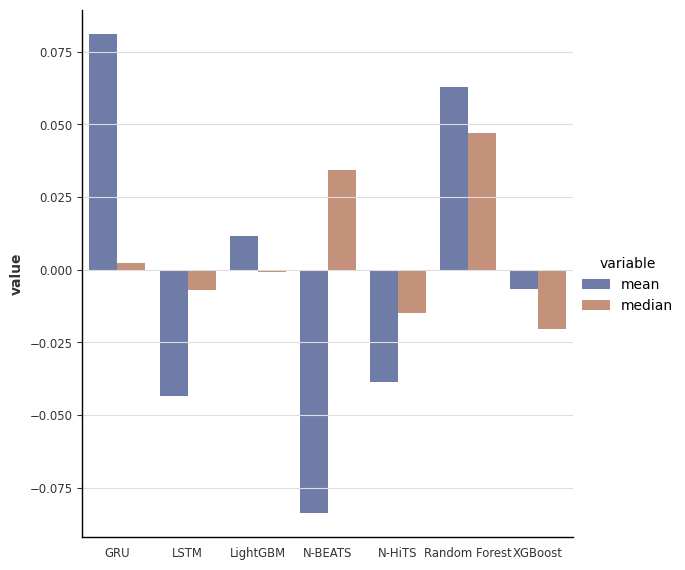

In [ ]:
apr_diff = apr_tuned_comparison[['model_name_proper', 'diff']].groupby(by=['model_name_proper'])\
                                                   .agg(median = ('diff','median'), mean= ('diff','mean')).reset_index()

apr_diff = pd.melt(apr_diff, id_vars=['model_name_proper'], value_vars=['mean', 'median'])

tick_fontsize = 15
g = sns.catplot(
    data=apr_diff, kind="bar",
    x="model_name_proper", y="value", hue="variable",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xlabels('')



### Was N-Hits Significantly more efficient than N-Beats?

In [ ]:
n_deep_models = apr_data_outl_cond[(apr_data_outl_cond['model_name_proper'].isin(['N-BEATS', 'N-HiTS']))].loc[:,['forecast_horizon','model_name', 'training_time', 'rmse']]
n_deep_models.head()

,forecast_horizon,model_name,training_time,rmse
120,1,NBEATS-G,29.786,0.0761
121,3,NBEATS-G,29.717,2.1794
122,7,NBEATS-G,30.052,1.8087
123,14,NBEATS-G,29.844,1.5937
124,28,NBEATS-G,30.301,1.2769


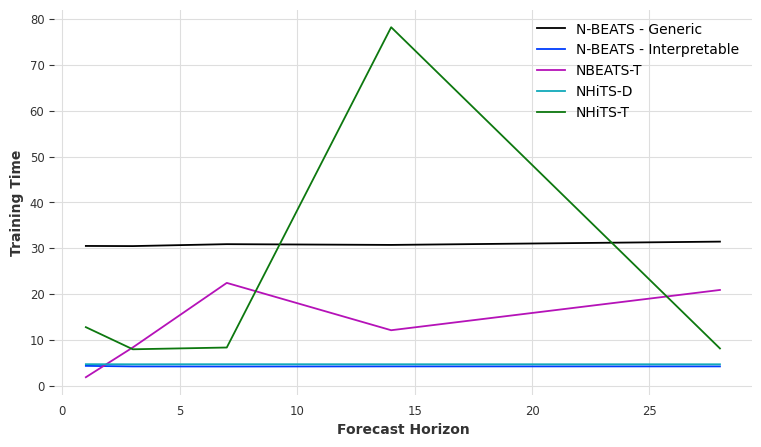

In [ ]:
avg_rmse = n_deep_models.groupby(by=['model_name', 'forecast_horizon']).mean().reset_index()
avg_rmse['model_name2'] = avg_rmse.apply(lambda row: 'N-HiTS Default' if row['model_name'] == 'N-HiTS-D'
                                                  else 'N-HiTS Tuned' if row['model_name'] == 'N-HiTS-TO'
                                                  else 'N-BEATS - Generic' if row['model_name'] == 'NBEATS-G'
                                                  else 'N-BEATS - Interpretable' if row['model_name'] == 'NBEATS-I'
                                                  else 'N-BEATS - Tuned' if row['model_name'] == 'NBEATS-TO'
                                                  else row['model_name'],
                                                  axis=1)

fig, ax = plt.subplots(figsize=(9, 5))
g = sns.lineplot(data=avg_rmse, x='forecast_horizon', y='training_time', hue='model_name2')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
g.set_xlabel('Forecast Horizon')
g.set_ylabel('Training Time')
g.legend(title='')

fig.show()

In [ ]:
importlib.reload(pf)

<module 'project_code.processing_functions' from '/content/gdrive/MyDrive/MRP/project_code/processing_functions.py'>

In [ ]:
median_rmse = n_deep_models.groupby(by=['model_name']).median().reset_index()
median_rmse['model_name2'] = median_rmse.apply(lambda row: 'N-HiTS - Default' if row['model_name'] == 'N-HiTS-D'
                                                  else 'N-HiTS- Tuned' if row['model_name'] == 'N-HiTS-TO'
                                                  else 'N-BEATS - Generic' if row['model_name'] == 'NBEATS-G'
                                                  else 'N-BEATS - Interpretable' if row['model_name'] == 'NBEATS-I'
                                                  else 'N-BEATS - Tuned' if row['model_name'] == 'NBEATS-TO'
                                                  else row['model_name'],
                                                  axis=1)

median_rmse = median_rmse.sort_values(by='rmse', ascending=True)

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots


# fig, ax = plt.subplots(figsize=(10, 5))
vf.dual_bar_chart(df=median_rmse, x='model_name2', y1='rmse', y2='training_time',
                y1_label='RMSE', y2_label='Training Time',y1_color='purple', y2_color='skyblue',
                font_size=14, align_axes=True, name='median_rmse_nbeats_nhits')

### X. What were the best models of each type (i.e. Standard M/DL, Novel DL, Ensemble)?

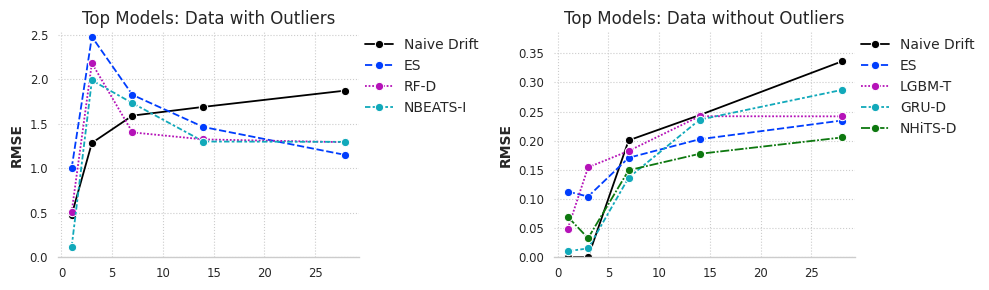

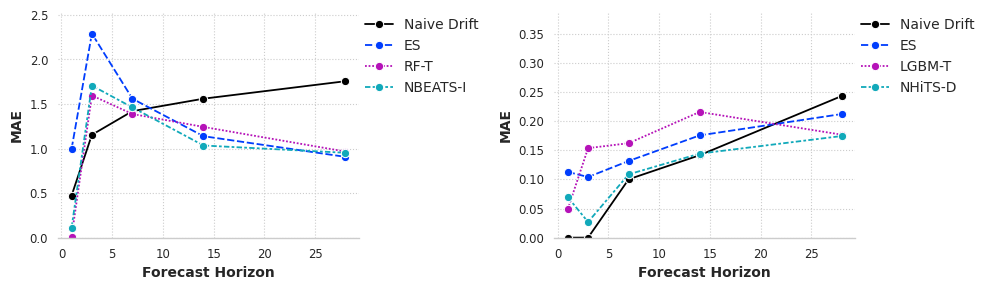

In [ ]:
best_models_outliers_rmse = ['Naive Drift', 'ES',  'GRU-TO', 'NBEATS-I', 'RF-D']
best_models_outliers_mae = ['Naive Drift', 'ES',  'GRU-TO', 'NBEATS-I', 'RF-T'] # only RF is diff from above
best_models_no_outl_rmse = ['Naive Drift', 'ES',  'GRU-D', 'NHiTS-D', 'LGBM-T']
best_models_no_outl_mae = ['Naive Drift', 'ES',  'GRU-TO', 'NHiTS-D', 'LGBM-T'] # GRU is the only one different


best_rmse_o = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_outliers_rmse)) & (apr_data_outl_cond['has_outliers'] == True)]
best_mae_o = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_outliers_mae)) & (apr_data_outl_cond['has_outliers'] == True)]
best_rmse_no = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_no_outl_rmse)) & (apr_data_outl_cond['has_outliers'] == False)]
best_mae_no = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_no_outl_mae)) & (apr_data_outl_cond['has_outliers'] == False)]

sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
y_max1 = max(best_rmse_o['rmse'].max(), best_mae_o['mae'].max()) + .05
y_max2 = max(best_rmse_no['rmse'].max(), best_mae_no['mae'].max()) + .05

g1 = sns.lineplot(ax=axes[0], data=best_rmse_o, x='forecast_horizon', y='rmse', hue='model_name',
                  style='model_name', marker='o')
g1.set_title('Top Models: Data with Outliers')
g1.set_xlabel('')
g1.set_ylabel('RMSE')
g1.set_ylim(0, y_max1)
g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.lineplot(ax=axes[1], data=best_rmse_no, x='forecast_horizon', y='rmse', hue='model_name',
                  style='model_name', marker='o')
g2.set_title('Top Models: Data without Outliers')
g2.set_xlabel('')
g2.set_ylabel('RMSE')
g2.set_ylim(0, y_max2)
g2.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

fig.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.lineplot(ax=axes[0], data=best_mae_o, x='forecast_horizon', y='mae', hue='model_name',
                  style='model_name', marker='o')
# g3.set_title('Top Models: Data with Outliers')
g3.set_xlabel('Forecast Horizon')
g3.set_ylabel('MAE')
g3.set_ylim(0, y_max1)
g3.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g4 = sns.lineplot(ax=axes[1], data=best_mae_no, x='forecast_horizon', y='mae', hue='model_name',
                  style='model_name', marker='o')
# g2.set_title('Top Models: Data without Outliers')
g4.set_xlabel('Forecast Horizon')
g4.set_ylabel('MAE')
g4.set_ylim(0, y_max2)
g4.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.tight_layout()



### Overall, how did the tuned models perform relative to the default models?

####RMSE

In [ ]:
error_metric = 'rmse'

apr['model_name_proper'] = apr['model_name_proper'].replace('Random Forest', 'RF')
aug['model_name_proper'] = aug['model_name_proper'].replace('Random Forest', 'RF')

apr_diff_rmse = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_rmse['best_model'] = apr_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


aug_diff_rmse = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_rmse['best_model'] = aug_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)




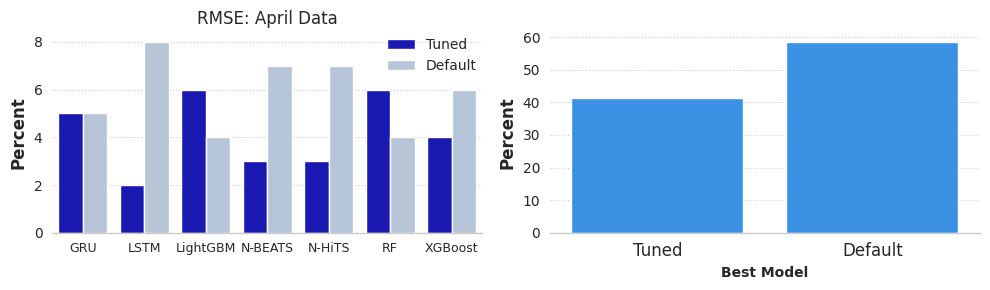

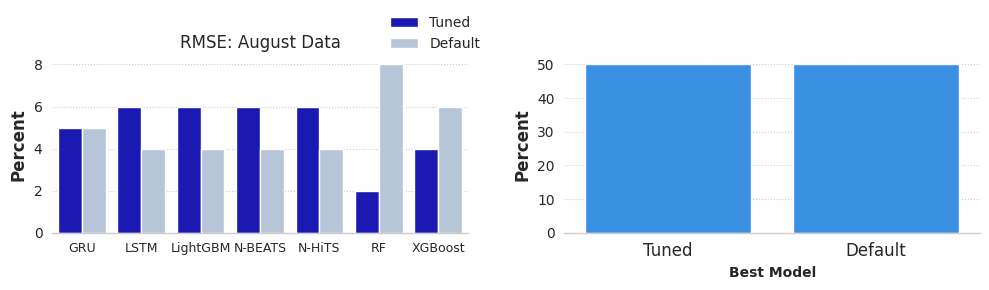

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_rmse, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('RMSE: April Data')
g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Percent', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_rmse, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_rmse, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('RMSE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Percent', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_rmse, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.show()



#### MAE

In [ ]:
error_metric = 'mae'

apr_diff_mae = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_mae['best_model'] = apr_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)

aug_diff_mae = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_mae['best_model'] = aug_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


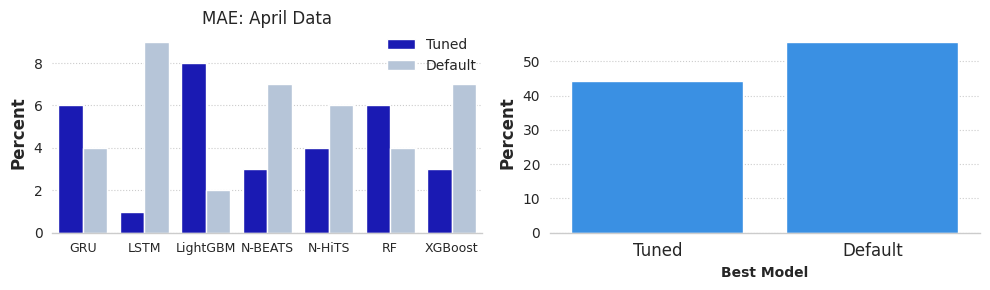

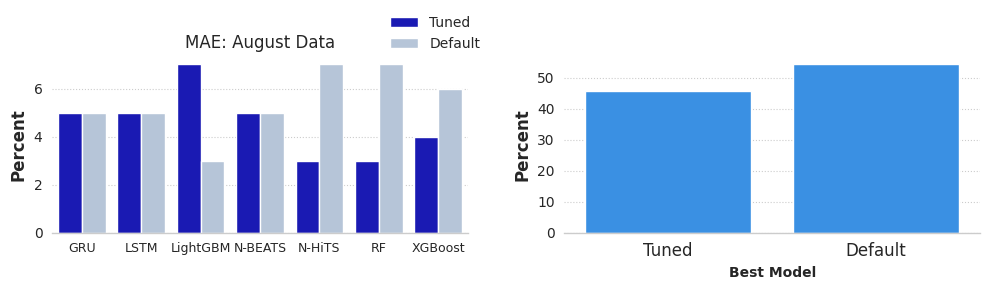

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_mae, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('MAE: April Data')

g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Percent', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_mae, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_mae, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('MAE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Percent', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_mae, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.show()


In [ ]:
## Latex Code for Report
print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)


print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)




------------------ Hyperparam-Outlier Condition - Outlier Dataset: April RMSE ------------------

Latex Version: 

\begin{tabular}{lrrrrrrr}
FH & FH-1 & FH-3 & FH-7 & FH-14 & FH-28 & Median & Mean \\
model_name &  &  &  &  &  &  &  \\
ES & 0.998 & 2.477 & 1.824 & 1.463 & 1.149 & 1.463 & 1.562 \\
GRU-D & 0.176 & 2.236 & 1.546 & 1.378 & 1.148 & 1.378 & 1.310 \\
GRU-T & 1.010 & 2.333 & 1.684 & 1.366 & \bfseries \color{darkgreen} 1.081 & 1.366 & 1.474 \\
LGBM-D & 0.248 & 1.847 & 1.637 & 1.391 & 1.246 & 1.391 & 1.293 \\
LGBM-T & 0.482 & 1.641 & 1.520 & 1.456 & 1.125 & 1.456 & 1.280 \\
LSTM-D & 0.198 & 2.122 & 1.579 & 1.371 & 1.192 & 1.371 & 1.306 \\
LSTM-T & 0.910 & 2.466 & \bfseries \color{firebrick} 1.826 & 1.479 & 1.262 & 1.479 & 1.570 \\
NBEATS-G & 0.076 & 2.179 & 1.809 & 1.594 & 1.277 & 1.594 & 1.421 \\
NBEATS-I & 0.112 & 1.987 & 1.731 & \bfseries \color{darkgreen} 1.300 & 1.296 & \bfseries \color{darkgreen} 1.300 & 1.288 \\
NBEATS-T & 0.592 & 2.326 & nan & 1.559 & 1.427 & 1.493 & 1.